# Introduction
This notebook contains a working example of the Similarity Based Saliency Maps (SBSM) API for transforming input images into saliency heatmaps based on their similarity.

This will necessarily include the use of a deep model for feature vector generation that we will be determining the saliency for.
We will fill this role here with a PyTorch Imagenet-pretrained ResNet18 network truncated after the last global average pooling layer.

### Table of Contents
* [Set Up Environment](#Set-Up-Environment-similarity)
* [The Test Images](#The-test-images-similarity)
* [Feature Extraction Model](#Feature-Extraction-Model)
* [Saliency Generator](#Saliency-Generator)
* [Generating Saliency](#Generating-Saliency)

### Miscellaneous
License for test images used may be found in 'COCO-LICENSE.txt'.

#### References
1. Dong, Bo, Roddy Collins, and Anthony Hoogs. "Explainability for Content-Based Image Retrieval." CVPR Workshops. 2019.

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/SimilarityScoring.ipynb)

# Set Up Environment <a name="Set-Up-Environment-similarity"></a>
**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys  # noqa

!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q "torch>=1.9.0"
!{sys.executable} -m pip install -q "torchvision>=0.10.0"

# The Test Images <a name="The-test-images-similarity"></a>
We will test this application on the following images.
We know that these images contains the Imagenet class of "boxer" and the superclass "dog".

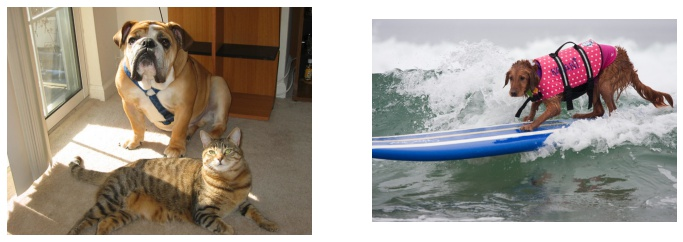

In [2]:
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

# Test images to be explained
os.makedirs("data", exist_ok=True)
test_image1_path = "data/catdog.jpg"
urllib.request.urlretrieve("https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg", test_image1_path)

test_image2_path = "data/dog.jpg"
urllib.request.urlretrieve("https://farm5.staticflickr.com/4089/4990202073_725f035a15_z.jpg", test_image2_path)

test_image1 = np.array(PIL.Image.open(test_image1_path))
test_image2 = np.array(PIL.Image.open(test_image2_path))

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(test_image1)
plt.subplot(1, 2, 2)
plt.axis("off")
_ = plt.imshow(test_image2)

# Feature-Extraction Model <a name="Feature-Extraction-Model"></a>
In this example, we will use a basic PyTorch-based, pretrained ResNet18 model truncated after the global average pooling (GAP) layer and use GAP's output as the feature vector representing content of the input image.
The ResNet18 model results in a 512 dimension feature vector after the GAP layer in a ResNet18.

This model is wrapped in an implementation of the `smqtk_descriptors.ImageDescriptorGenerator` interface to make it compatible with our saliency generation API.

Note that the `use_cuda` parameter can be set to `True` to accelerate computation if a CUDA device is available.

In [3]:
from collections.abc import Iterable

import torch
import torchvision.models as models
from smqtk_descriptors.interfaces.image_descriptor_generator import ImageDescriptorGenerator
from torch import nn
from torch.autograd import Variable
from torchvision import transforms


class ResNet18Generator(ImageDescriptorGenerator):
    def __init__(self, use_cuda=False) -> None:
        # load pretrained model
        model = models.resnet18(pretrained=True)
        # truncate model
        model = nn.Sequential(*list(model.children())[:-1])

        if use_cuda:
            model = model.cuda()
        self.use_cuda = use_cuda

        self.model = model.eval()

        self.model_input_size = (224, 224)
        self.model_mean = [0.485, 0.456, 0.406]
        self.blackbox_fill = np.uint8(np.asarray(self.model_mean) * 255)
        self.model_loader = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(self.model_input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.model_mean, std=[0.229, 0.224, 0.225]),
            ],
        )

    def image_loader(self, image):
        image = self.model_loader(image).float()
        image = Variable(image, requires_grad=False)
        if self.use_cuda:
            image = image.cuda()
        return image.unsqueeze(0)

    @torch.no_grad()
    def generate_arrays_from_images(self, img_mat_iter: Iterable[np.ndarray]) -> Iterable[np.ndarray]:
        for img_mat in img_mat_iter:
            feat = self.model(self.image_loader(img_mat))
            yield feat.cpu().detach().numpy().squeeze()

    # required by interface
    def get_config(self):
        return {}


desc_gen = ResNet18Generator(use_cuda=False)

# Saliency Generator <a name="Saliency-Generator"></a>

The `SBSMStack` class from `xaitk_saliency` generates similarity based saliency maps using a perturbation-occlusion approach.
Saliency is derived from differences in the output of our feature extractor when passing occluded versions of our reference image.

Specifically, this class uses the `SlidingWindow` image perturber and `SimilarityScoring` saliency map generation algorithms.

We set the generator to use the occlusion fill from our feature extractor.

In [4]:
from xaitk_saliency.impls.gen_image_similarity_blackbox_sal.sbsm import SBSMStack

sal_generator = SBSMStack(window_size=(40, 40), stride=(15, 15), fill=desc_gen.blackbox_fill, threads=4)

# Generating Saliency <a name="Generating-Saliency"></a>
Below, we demonstrate the ability to compute salient regions both between two images, "a" and "b", and the same image.
Regions within computed self-similarity generally track the regions encoded by the feature vector.

* a -> b
* b -> a
* a -> a
* b -> b

Note that the original implementation of SBSM intentionally constrains its saliency values to the [0,1] range due to only trying to explain regions of positive influence. Therefore the negative saliency maps appear to be empty.

Saliency is computed for the reference image, which is compared to each of the specified query images.

/home/local/KHQ/elim.schenck/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Saliency map range: [0, 1]


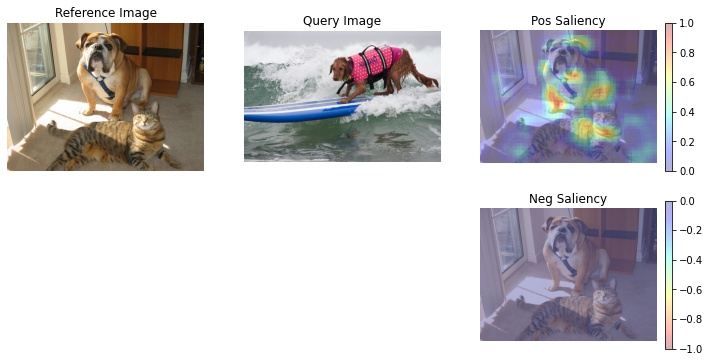

Saliency map range: [0.0607, 1]


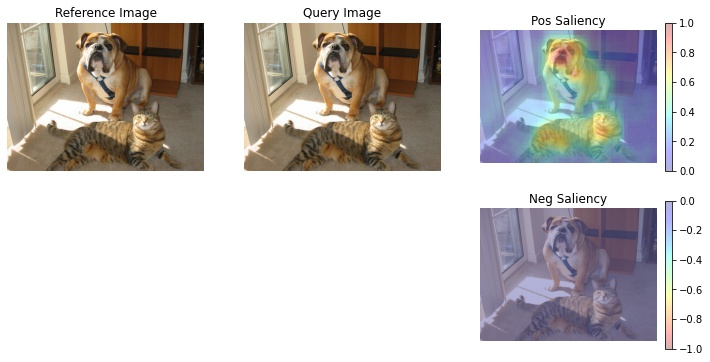

Saliency map range: [0, 1]


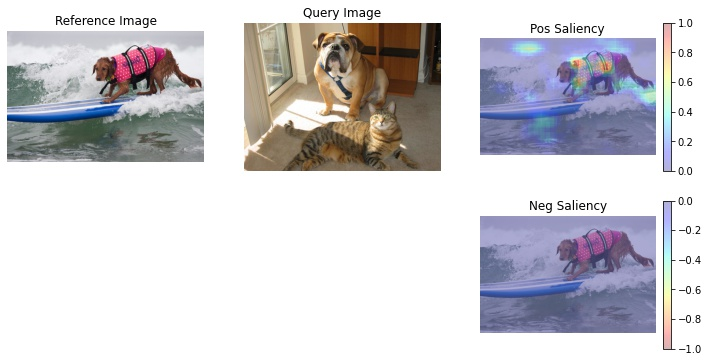

Saliency map range: [0.079, 1]


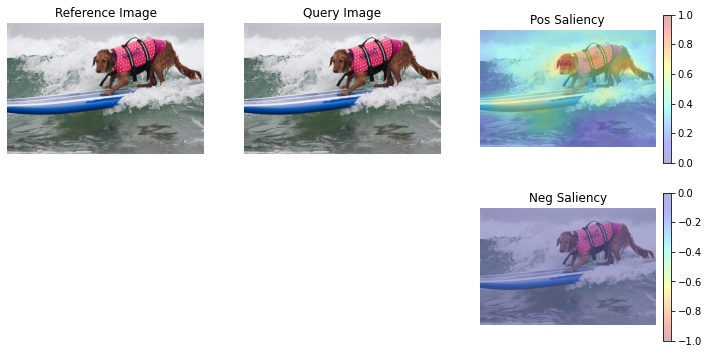

In [5]:
# display images and saliency map in a nice format
def show_sal_map(ref_image, query_image, sal_map) -> None:
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(ref_image)
    plt.axis("off")
    plt.title("Reference Image")

    plt.subplot(2, 3, 2)
    plt.imshow(query_image)
    plt.axis("off")
    plt.title("Query Image")

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046 * (ref_image.shape[1] / ref_image.shape[0]),
        "pad": 0.04,
    }

    print(f"Saliency map range: [{sal_map.min():.3g}, {sal_map.max():.3g}]")

    # Positive half saliency
    plt.subplot(2, 3, 3)
    plt.imshow(ref_image, alpha=0.7)
    plt.imshow(np.clip(sal_map, 0, 1), cmap="jet", alpha=0.3)
    plt.clim(0, 1)
    plt.colorbar(**colorbar_kwargs)
    plt.title("Pos Saliency")
    plt.axis("off")

    # Negative half saliency
    plt.subplot(2, 3, 6)
    plt.imshow(ref_image, alpha=0.7)
    plt.imshow(np.clip(sal_map, -1, 0), cmap="jet_r", alpha=0.3)
    plt.clim(-1, 0)
    plt.colorbar(**colorbar_kwargs)
    plt.title("Neg Saliency")
    plt.axis("off")
    plt.show()
    plt.close()


# Computing saliency across all combinations of the two test images as query
# and reference images for Sliding Window-based perturbation

# a -> b
# a -> a
sal_maps = sal_generator(ref_image=test_image1, query_images=[test_image2, test_image1], blackbox=desc_gen)
show_sal_map(test_image1, test_image2, sal_maps[0])
show_sal_map(test_image1, test_image1, sal_maps[1])

# b -> a
# b -> b
sal_maps = sal_generator(ref_image=test_image2, query_images=[test_image1, test_image2], blackbox=desc_gen)
show_sal_map(test_image2, test_image1, sal_maps[0])
show_sal_map(test_image2, test_image2, sal_maps[1])